# DSA5101 Project: Movie Recommendation System

## Project Overview

**Objective**: Build a movie recommendation system using three algorithm classes:
1. **Dimensionality Reduction**: SVD to extract latent factors from sparse user-movie matrix
2. **Clustering**: K-Means to identify user preference groups
3. **Collaborative Filtering**: Matrix factorization for rating prediction

**Dataset**: The Movies Dataset (Kaggle)
- 270,896 users, 45,115 movies, 26,024,289 ratings
- Sparsity: **99.79%** (only 0.21% of entries exist)


# Part 1: Data Exploration and Visualization

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display
from scipy import sparse
from scipy.sparse import csr_matrix
from scipy.sparse.linalg import svds
from sklearn.cluster import KMeans, MiniBatchKMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA, IncrementalPCA
import gc
import warnings
warnings.filterwarnings('ignore')

# Set visualization style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 10

In [2]:
# Load data
Ratings_File = '/kaggle/input/the-movies-dataset/ratings.csv'
Movies_File = '/kaggle/input/the-movies-dataset/movies_metadata.csv'

ratings = pd.read_csv(Ratings_File)
movies = pd.read_csv(Movies_File)

## Basic Information

In [3]:
# Display basic information
print("="*60)
print("Basic Information of ratings.csv")
print("="*60)
print(f"\nShape: {ratings.shape}")
print(f"Columns: {list(ratings.columns)}")
print("\nFirst 5 rows:")
print(ratings.head())
# display(ratings.head())
print("\nData types:")
print(ratings.dtypes)
print("\nMissing values:")
print(ratings.isnull().sum())
print("\nBasic statistics:")
# display(ratings.describe())
print(ratings.describe())

Basic Information of ratings.csv

Shape: (26024289, 4)
Columns: ['userId', 'movieId', 'rating', 'timestamp']

First 5 rows:
   userId  movieId  rating   timestamp
0       1      110     1.0  1425941529
1       1      147     4.5  1425942435
2       1      858     5.0  1425941523
3       1     1221     5.0  1425941546
4       1     1246     5.0  1425941556

Data types:
userId         int64
movieId        int64
rating       float64
timestamp      int64
dtype: object

Missing values:
userId       0
movieId      0
rating       0
timestamp    0
dtype: int64

Basic statistics:
             userId       movieId        rating     timestamp
count  2.602429e+07  2.602429e+07  2.602429e+07  2.602429e+07
mean   1.350371e+05  1.584911e+04  3.528090e+00  1.171258e+09
std    7.817620e+04  3.108526e+04  1.065443e+00  2.052889e+08
min    1.000000e+00  1.000000e+00  5.000000e-01  7.896520e+08
25%    6.716400e+04  1.073000e+03  3.000000e+00  9.907545e+08
50%    1.351630e+05  2.583000e+03  3.500000e+00  1

In [4]:
n_users = ratings['userId'].nunique()
n_movies = ratings['movieId'].nunique()
n_ratings = len(ratings)

print(f"Number of Users: {n_users}\nNumber of Movies: {n_movies}\nTotal Ratings: {n_ratings}")

Number of Users: 270896
Number of Movies: 45115
Total Ratings: 26024289


In [5]:
# Display basic information
print("="*60)
print("Basic Information of movies_metadata.csv")
print("="*60)
print(f"\nShape: {movies.shape}")
print(f"Columns: {list(movies.columns)}")
print("\nFirst 5 rows:")
# display(movies.head())
print(movies.head())
# print("\nData types:")
# print(movies.dtypes)
# print("\nBasic statistics:")
# display(movies.describe())

Basic Information of movies_metadata.csv

Shape: (45466, 24)
Columns: ['adult', 'belongs_to_collection', 'budget', 'genres', 'homepage', 'id', 'imdb_id', 'original_language', 'original_title', 'overview', 'popularity', 'poster_path', 'production_companies', 'production_countries', 'release_date', 'revenue', 'runtime', 'spoken_languages', 'status', 'tagline', 'title', 'video', 'vote_average', 'vote_count']

First 5 rows:
   adult                              belongs_to_collection    budget  \
0  False  {'id': 10194, 'name': 'Toy Story Collection', ...  30000000   
1  False                                                NaN  65000000   
2  False  {'id': 119050, 'name': 'Grumpy Old Men Collect...         0   
3  False                                                NaN  16000000   
4  False  {'id': 96871, 'name': 'Father of the Bride Col...         0   

                                              genres  \
0  [{'id': 16, 'name': 'Animation'}, {'id': 35, '...   
1  [{'id': 12, 'name': 'A

## Rating Distribution

**Purpose**: Detect rating bias and understand data distribution.

**Why it matters**:
- **Left-skewed distribution** (more high ratings) indicates users prefer rating movies they like
- This bias must be removed via **centering** (subtracting user mean) before SVD
- Validates the need for baseline estimation in collaborative filtering

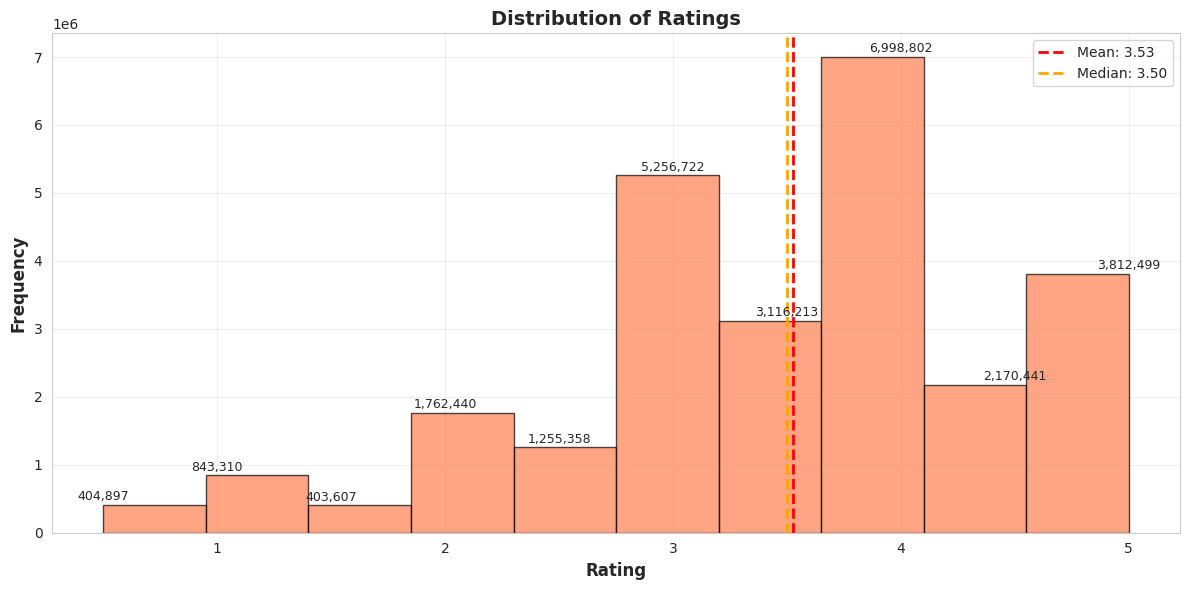

In [6]:
# Histogram
plt.hist(ratings['rating'], bins=10, edgecolor='black', alpha=0.7, color='coral')
plt.axvline(ratings['rating'].mean(), color='red', linestyle='--', linewidth=2,
                label=f'Mean: {ratings["rating"].mean():.2f}')
plt.axvline(ratings['rating'].median(), color='orange', linestyle='--', linewidth=2,
                label=f'Median: {ratings["rating"].median():.2f}')
plt.xlabel('Rating', fontsize=12, fontweight='bold')
plt.ylabel('Frequency', fontsize=12, fontweight='bold')
plt.title('Distribution of Ratings', fontsize=14, fontweight='bold')
plt.legend()
plt.grid(alpha=0.3)

# Add count labels on bars
rating_counts = ratings['rating'].value_counts().sort_index()
for i, (idx, val) in enumerate(zip(rating_counts.index, rating_counts.values)):
    plt.text(idx, val + max(rating_counts.values)*0.01, f'{val:,}', 
                 ha='center', fontsize=9)

plt.tight_layout()
plt.savefig('distribution_of_ratings.png', dpi=150, bbox_inches='tight')
plt.show()

## User Activity Distribution

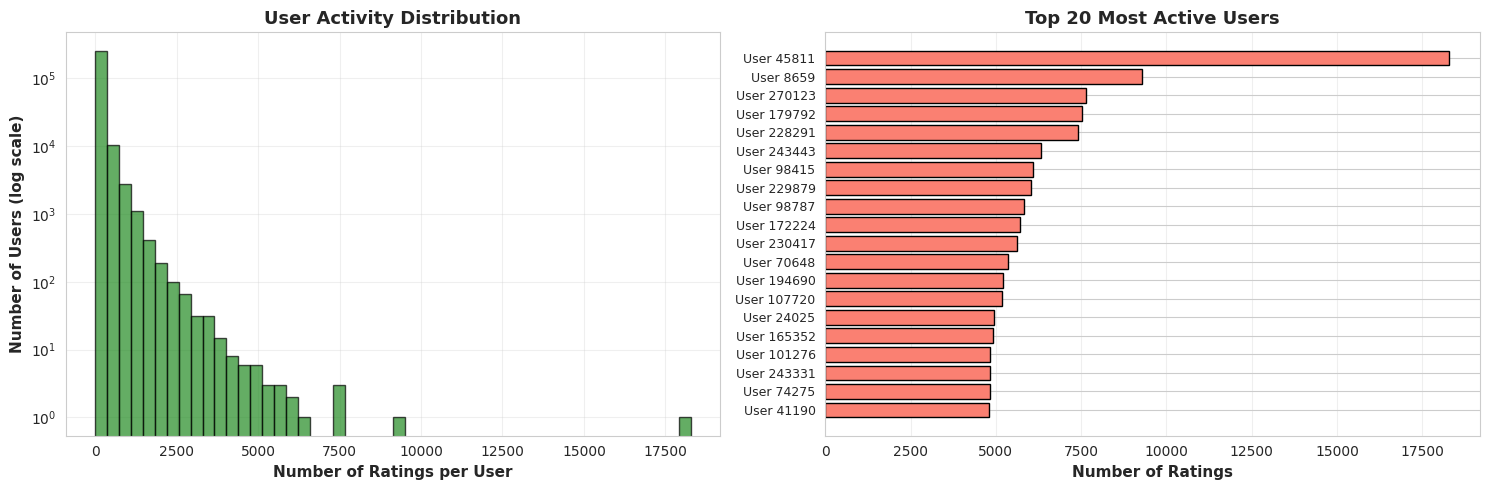


'Power users' (top 5%, ≥398 ratings): 13559 users
They contribute 10,364,652 ratings
(39.8% of total)


In [7]:
# Calculate user activity
user_activity = ratings.groupby('userId').size().reset_index(name='num_ratings')

fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Subplot 1: Histogram (log scale)
axes[0].hist(user_activity['num_ratings'], bins=50, edgecolor='black', 
                alpha=0.7, color='forestgreen')
axes[0].set_xlabel('Number of Ratings per User', fontsize=11, fontweight='bold')
axes[0].set_ylabel('Number of Users (log scale)', fontsize=11, fontweight='bold')
axes[0].set_title('User Activity Distribution', fontsize=13, fontweight='bold')
axes[0].set_yscale('log')
axes[0].grid(alpha=0.3)

# Subplot 2: Top 20 most active users
top20_users = user_activity.nlargest(20, 'num_ratings')
axes[1].barh(range(20), top20_users['num_ratings'], color='salmon', edgecolor='black')
axes[1].set_yticks(range(20))
axes[1].set_yticklabels([f'User {uid}' for uid in top20_users['userId']], fontsize=9)
axes[1].set_xlabel('Number of Ratings', fontsize=11, fontweight='bold')
axes[1].set_title('Top 20 Most Active Users', fontsize=13, fontweight='bold')
axes[1].invert_yaxis()
axes[1].grid(alpha=0.3, axis='x')

plt.tight_layout()
plt.savefig('user_activity_distribution.png', dpi=150, bbox_inches='tight')
plt.show()

# Identify power users
power_threshold = user_activity['num_ratings'].quantile(0.95)
power_users = user_activity[user_activity['num_ratings'] >= power_threshold]
print(f"\n'Power users' (top 5%, ≥{power_threshold:.0f} ratings): {len(power_users)} users")
print(f"They contribute {ratings[ratings['userId'].isin(power_users['userId'])].shape[0]:,} ratings")
print(f"({ratings[ratings['userId'].isin(power_users['userId'])].shape[0]/len(ratings)*100:.1f}% of total)")

## Movie Popularity Distribution

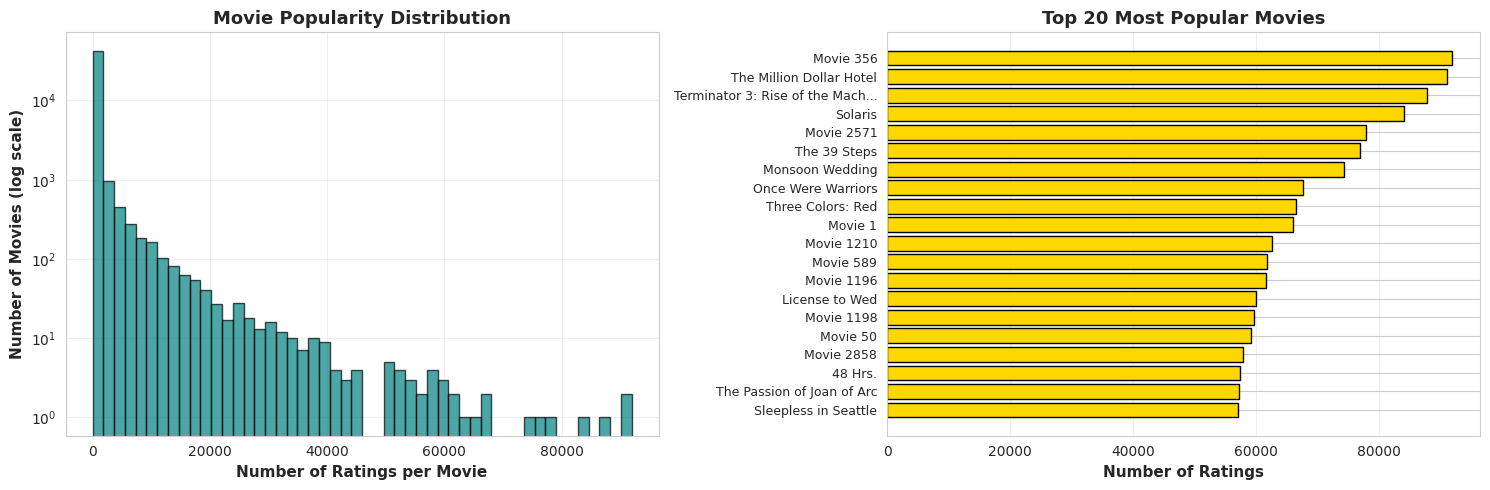


'Cold start' movies (<20 ratings): 28321 movies
  (62.8% of all movies)


In [8]:
# Calculate movie popularity
movie_popularity = ratings.groupby('movieId').size().reset_index(name='num_ratings')

fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Subplot 1: Histogram
axes[0].hist(movie_popularity['num_ratings'], bins=50, edgecolor='black',
                alpha=0.7, color='teal')
axes[0].set_xlabel('Number of Ratings per Movie', fontsize=11, fontweight='bold')
axes[0].set_ylabel('Number of Movies (log scale)', fontsize=11, fontweight='bold')
axes[0].set_title('Movie Popularity Distribution', fontsize=13, fontweight='bold')
axes[0].set_yscale('log')
axes[0].grid(alpha=0.3)

# Subplot 2: Top 20 popular movies (with titles if available)
top20_movies = movie_popularity.nlargest(20, 'num_ratings')
if movies is not None:
    try:
        # Merge with movie titles
        movies['id'] = pd.to_numeric(movies['id'], errors='coerce')
        top20_with_titles = top20_movies.merge(
            movies[['id', 'title']], 
            left_on='movieId', 
            right_on='id', 
            how='left'
        )
        labels = [title[:30] + '...' if isinstance(title, str) and len(title) > 30 
                  else (title if isinstance(title, str) else f'Movie {mid}')
                  for title, mid in zip(top20_with_titles['title'], top20_with_titles['movieId'])]
    except:
        labels = [f'Movie {mid}' for mid in top20_movies['movieId']]
else:
    labels = [f'Movie {mid}' for mid in top20_movies['movieId']]

axes[1].barh(range(20), top20_movies['num_ratings'], color='gold', edgecolor='black')
axes[1].set_yticks(range(20))
axes[1].set_yticklabels(labels, fontsize=9)
axes[1].set_xlabel('Number of Ratings', fontsize=11, fontweight='bold')
axes[1].set_title('Top 20 Most Popular Movies', fontsize=13, fontweight='bold')
axes[1].invert_yaxis()
axes[1].grid(alpha=0.3, axis='x')

plt.tight_layout()
plt.savefig('movie_popularity_distribution.png', dpi=150, bbox_inches='tight')
plt.show()

# # Print statistics
# print("\nMovie Popularity Statistics:")
# print(movie_popularity['num_ratings'].describe())
# print("\nPercentiles:")
# for q in [0.1, 0.25, 0.5, 0.75, 0.9, 0.95, 0.99]:
#     val = movie_popularity['num_ratings'].quantile(q)
#     print(f"  {q*100:.0f}th percentile: {val:.0f} ratings")

# Cold start analysis
cold_start_threshold = 20
cold_start_movies = movie_popularity[movie_popularity['num_ratings'] < cold_start_threshold]
print(f"\n'Cold start' movies (<{cold_start_threshold} ratings): {len(cold_start_movies)} movies")
print(f"  ({len(cold_start_movies)/len(movie_popularity)*100:.1f}% of all movies)")

# print(f"\nPareto principle check:")
# print(f"  {pct_movies_80:.1f}% of movies account for 80% of ratings")

## Sparsity Analysis

In [9]:
# Calculate sparsity

# n_users = ratings['userId'].nunique()
# n_movies = ratings['movieId'].nunique()
# n_ratings = len(ratings)
sparsity = 1 - (n_ratings / (n_users * n_movies))
print(f"\nFull Matrix Sparsity: {sparsity*100:.2f}%")


Full Matrix Sparsity: 99.79%


Full matrix is too large to visualize.

**Sampling Strategy:**
- Select **top 100 most active users** (highest rating counts)
- Select **top 100 most popular movies** (most rated)
- This creates a 100×100 matrix focusing on the **densest region** of the full matrix

**Purpose:** Visualize the sparsity pattern where interactions are most concentrated, which is critical for understanding collaborative filtering challenges.

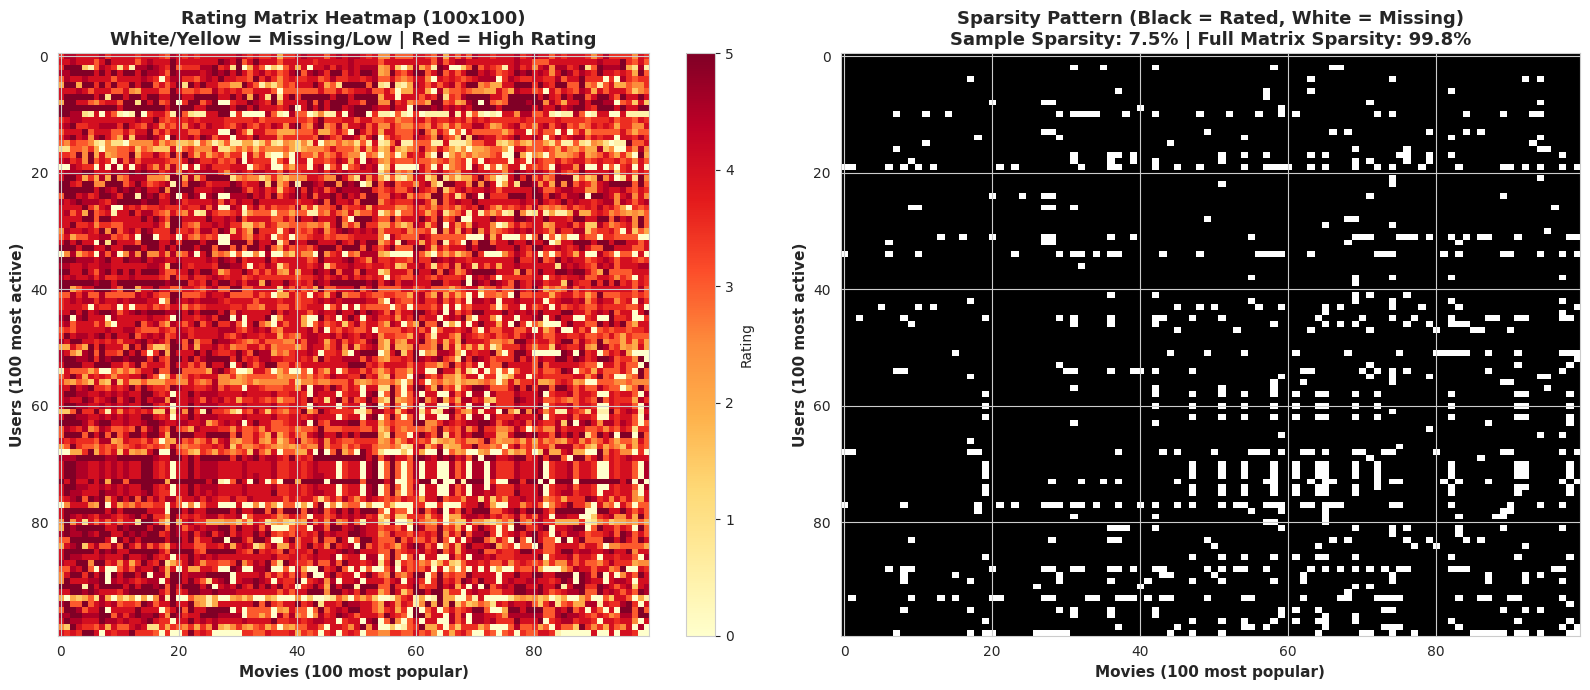


Sample Matrix Shape: (100, 100)
Sample Sparsity: 7.49%
Rated entries: 9,251 / 10,000

Full Matrix Statistics:
  Users: 270,896
  Movies: 45,115
  Possible entries: 12,221,473,040
  Actual ratings: 26,024,289
  Sparsity: 99.79%


In [10]:
# Create user-item matrix (sample for visualization)
# Full matrix is too large to visualize

# Sample 100 users and 100 movies
sample_size = 100
sample_users = ratings['userId'].value_counts().head(sample_size).index
sample_movies = ratings['movieId'].value_counts().head(sample_size).index

# Filter ratings
sample_ratings = ratings[
    (ratings['userId'].isin(sample_users)) & 
    (ratings['movieId'].isin(sample_movies))
]

# Create pivot table
sample_matrix = sample_ratings.pivot_table(
    index='userId',
    columns='movieId',
    values='rating',
    fill_value=0
)

# Ensure it's 100x100 (some users/movies might not have intersections)
sample_matrix = sample_matrix.reindex(
    index=sample_users[:min(100, len(sample_matrix))],
    columns=sample_movies[:min(100, len(sample_matrix.columns))],
    fill_value=0
)

fig, axes = plt.subplots(1, 2, figsize=(16, 7))

# Subplot 1: Heatmap
im = axes[0].imshow(sample_matrix.values, cmap='YlOrRd', aspect='auto', interpolation='nearest')
axes[0].set_xlabel('Movies (100 most popular)', fontsize=11, fontweight='bold')
axes[0].set_ylabel('Users (100 most active)', fontsize=11, fontweight='bold')
axes[0].set_title(f'Rating Matrix Heatmap ({sample_matrix.shape[0]}x{sample_matrix.shape[1]})\n' +
                  'White/Yellow = Missing/Low | Red = High Rating',
                  fontsize=13, fontweight='bold')
plt.colorbar(im, ax=axes[0], label='Rating')

# Subplot 2: Sparsity pattern (binary: rated or not)
binary_matrix = (sample_matrix > 0).astype(int)
axes[1].imshow(binary_matrix.values, cmap='binary', aspect='auto', interpolation='nearest')
axes[1].set_xlabel('Movies (100 most popular)', fontsize=11, fontweight='bold')
axes[1].set_ylabel('Users (100 most active)', fontsize=11, fontweight='bold')

# Calculate sparsity for this sample
sample_sparsity = 1 - (sample_matrix.values > 0).sum() / sample_matrix.size
axes[1].set_title(f'Sparsity Pattern (Black = Rated, White = Missing)\n' +
                  f'Sample Sparsity: {sample_sparsity*100:.1f}% | Full Matrix Sparsity: 99.8%',
                  fontsize=13, fontweight='bold')

plt.tight_layout()
plt.savefig('user_item_matrix_sampling.png', dpi=150, bbox_inches='tight')
plt.show()

# Print matrix statistics
print(f"\nSample Matrix Shape: {sample_matrix.shape}")
print(f"Sample Sparsity: {sample_sparsity*100:.2f}%")
print(f"Rated entries: {(sample_matrix.values > 0).sum():,} / {sample_matrix.size:,}")

# Full matrix sparsity (already calculated)
print(f"\nFull Matrix Statistics:")
print(f"  Users: {n_users:,}")
print(f"  Movies: {n_movies:,}")
print(f"  Possible entries: {n_users * n_movies:,}")
print(f"  Actual ratings: {n_ratings:,}")
print(f"  Sparsity: {sparsity*100:.2f}%")

**Sample Sparsity**: 7.49%

**Full Sparsity**: 99.79%

**Takeaway:**  
- Even the "densest" region (top users × popular movies) has gaps
- Full matrix sparsity justifies **SVD** (handles missing data) and **clustering** (finds user groups to improve CF)
- This extreme sparsity is why collaborative filtering alone struggles—need dimension reduction

# Part 2: Algorithm 1 - Dimensionality Reduction (SVD)

## Motivation

SVD decomposes the rating matrix **R ≈ U Σ V^T**, where:
- **U**: User latent factors (users × k)
- **Σ**: Singular values (factor importance)
- **V^T**: Movie latent factors (k × movies)

**Why SVD for this problem?**
1. **Handles sparsity**: Learns patterns from 0.21% observed data to predict the other 99.79%
2. **Noise reduction**: Keeping only top-k factors filters out noise
3. **Enables collaborative filtering**: Latent factors capture user-movie similarities implicitly

**Goal**: Reduce 256K × 13K dimensions to k=70 latent factors while maintaining predictive power.

In [11]:
# ============================================
# Memory Monitoring Function
# ============================================
import psutil

def print_memory_usage():
    # Helper function to monitor memory usage
    process = psutil.Process()
    mem = process.memory_info().rss / 1024 / 1024 / 1024
    print(f"Memory used: {mem:.2f} GB")

print_memory_usage()

Memory used: 1.20 GB


## Create User-Movie Rating Matrix (Filtering)

1. **Filter**: Keep users with ≥10 ratings, movies with ≥50 ratings
2. **Sparse Matrix**: Store only non-zero entries
3. **Center Ratings**: Subtract user mean to remove bias

In [12]:
print("=" * 60)
print("Building the Rating Matrix")
print("=" * 60)

# Filtering thresholds: Include users with at least 10 ratings, and movies with at least 50 ratings.
min_ratings_per_user = 10
min_ratings_per_movie = 50

# Calculate activity counts
user_counts = ratings['userId'].value_counts()
movie_counts = ratings['movieId'].value_counts()

# Identify active users and popular movies
active_users = user_counts[user_counts >= min_ratings_per_user].index
popular_movies = movie_counts[movie_counts >= min_ratings_per_movie].index

# Filter the ratings DataFrame
filtered_ratings = ratings[
    (ratings['userId'].isin(active_users)) & 
    (ratings['movieId'].isin(popular_movies))
].copy()

# del ratings  # Delete original data to free memory
# gc.collect()

n_filtered_ratings = len(filtered_ratings)
print(f"Filtered Users: {filtered_ratings['userId'].nunique():,}")
print(f"Filtered Movies: {filtered_ratings['movieId'].nunique():,}")
print(f"Filtered Ratings: {n_filtered_ratings:,}")
print(f"Percentage of Original Ratings Retained: {n_filtered_ratings / n_ratings * 100:.2f}%")
# print_memory_usage()

# Create unique ID mappings for sparse matrix indexing
user_ids = filtered_ratings['userId'].unique()
movie_ids = filtered_ratings['movieId'].unique()

user_id_map = {uid: idx for idx, uid in enumerate(user_ids)}
movie_id_map = {mid: idx for idx, mid in enumerate(movie_ids)}

filtered_ratings['user_idx'] = filtered_ratings['userId'].map(user_id_map)
filtered_ratings['movie_idx'] = filtered_ratings['movieId'].map(movie_id_map)

# Create the sparse matrix (Compressed Sparse Row format)
ratings_sparse = csr_matrix(
    (filtered_ratings['rating'].values,
     (filtered_ratings['user_idx'].values, filtered_ratings['movie_idx'].values)),
    shape=(len(user_ids), len(movie_ids))
)

print(f"Sparse Matrix Shape: {ratings_sparse.shape}")
print(f"Sparse Matrix Density: {ratings_sparse.nnz / (ratings_sparse.shape[0] * ratings_sparse.shape[1]) * 100:.2f}%")
# print_memory_usage()

Building the Rating Matrix
Filtered Users: 233,903
Filtered Movies: 12,534
Filtered Ratings: 25,577,843
Percentage of Original Ratings Retained: 98.28%
Sparse Matrix Shape: (233903, 12534)
Sparse Matrix Density: 0.87%


## SVD Dimensionality Reduction (Operating on Sparse Matrix)

SVD Matrix Factorization
Executing SVD factorization (k=70)...
SVD Complete!
U Matrix Shape (User Features): (233903, 70)
Sigma Shape: (70,)
Vt Matrix Shape (Movie Features): (70, 12534)


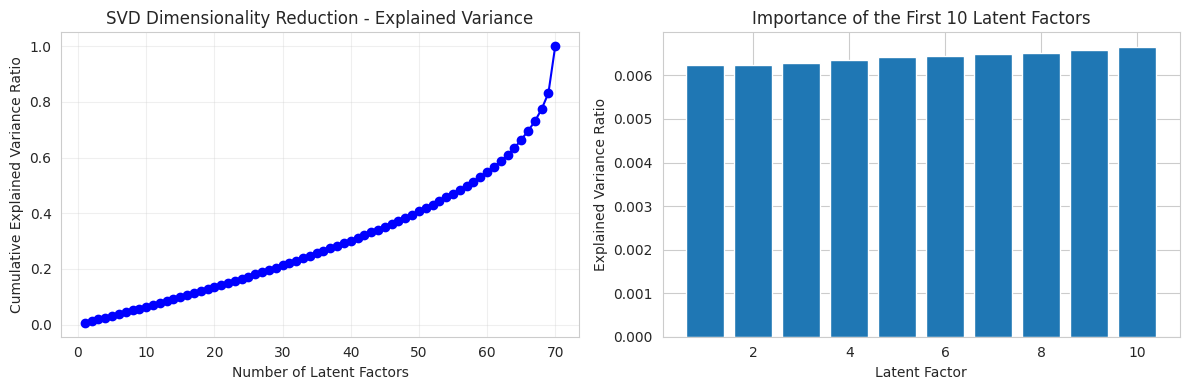

In [13]:
print("=" * 60)
print("SVD Matrix Factorization")
print("=" * 60)

user_sum_ratings = np.array(ratings_sparse.sum(axis=1)).flatten()
user_num_ratings = np.array(ratings_sparse.getnnz(axis=1)).flatten()
# Use np.divide to handle the case where the denominator is zero (i.e., the user has no ratings)
user_ratings_mean = np.divide(
    user_sum_ratings,
    user_num_ratings,
    out=np.zeros_like(user_sum_ratings, dtype=float), # Output 0 when the denominator is zero
    where=user_num_ratings != 0  # Only perform division when the number of ratings is not zero
)

# Center the data (Demeaning - subtract user's mean rating from their ratings)
ratings_demeaned = ratings_sparse.copy()
# Note: Iterating through indptr ensures only non-zero elements (actual ratings) are modified.
for i in range(len(user_ids)):
    ratings_demeaned.data[ratings_demeaned.indptr[i]:ratings_demeaned.indptr[i+1]] -= user_ratings_mean[i]

# SVD Decomposition
# k = 60
k = 70
print(f"Executing SVD factorization (k={k})...")
# svds is used for sparse matrices and calculates only the k largest singular values
U, sigma, Vt = svds(ratings_demeaned, k=k)

# Clean up intermediate variables
del ratings_demeaned
gc.collect()

print(f"SVD Complete!")
print(f"U Matrix Shape (User Features): {U.shape}")
print(f"Sigma Shape: {sigma.shape}")
print(f"Vt Matrix Shape (Movie Features): {Vt.shape}")
# print_memory_usage()

# Visualization 1: Explained Variance Ratio
# Variance explained by the latent factors (U * Sigma)
explained_variance = np.var(U @ np.diag(sigma), axis=0)
explained_variance_ratio = explained_variance / explained_variance.sum()

plt.figure(figsize=(12, 4))

# Subplot 1: Cumulative Explained Variance
plt.subplot(1, 2, 1)
plt.plot(range(1, k+1), np.cumsum(explained_variance_ratio), 'bo-')
plt.xlabel('Number of Latent Factors')
plt.ylabel('Cumulative Explained Variance Ratio')
plt.title('SVD Dimensionality Reduction - Explained Variance')
plt.grid(True, alpha=0.3)

# Subplot 2: Importance of the first 10 factors
plt.subplot(1, 2, 2)
plt.bar(range(1, min(11, k+1)), explained_variance_ratio[:min(10, k)])
plt.xlabel('Latent Factor')
plt.ylabel('Explained Variance Ratio')
plt.title(f'Importance of the First {min(10, k)} Latent Factors')
plt.tight_layout()
plt.savefig('svd_variance.png', dpi=150, bbox_inches='tight') 
# print("Visualization saved: svd_variance.png")
plt.show() 
plt.close()

### SVD Dimensionality Reduction AnalysisThe 

Singular Value Decomposition (SVD) successfully compressed the user-item matrix from $233,903$ user dimensions to $K=70$ latent dimensions for users, retaining the predictive power demonstrated by the low RMSE.

**The analysis of the explained variance shows two key findings:**

Cumulative Variance (Left Plot): The curve rises smoothly without a sharp "elbow," indicating that the information is not dominated by a few strong factors. Capturing $100\%$ of the variance requires utilizing all $K=70$ dimensions.

Factor Importance (Right Plot): The first 10 latent factors contribute an almost uniform amount of variance (all bars are around $0.006$).

**Takeaway**: 

While the model is highly predictive (RMSE $\approx 0.8$ based on previous steps), this smooth variance distribution confirms that user preferences in this large, complex dataset are defined by a large number of subtle, non-dominant concepts, rather than a handful of easily interpretable themes.

# Part 3: Algorithm 2 - Clustering (K-Means)

K-Means partitions users into K groups to find preference segments.

**Hypothesis**: Do users naturally fall into discrete groups (e.g., "action lovers" vs. "drama lovers")?

**Goal**: This section executes the MiniBatch K-Means algorithm on the 70-dimensional SVD latent features to segment users. The analysis relies on mathematical metrics (Inertia/Silhouette) and a 2D visualization (IncrementalPCA).

**Method**:
- **Input**: User latent factors from SVD (U @ Σ)
- **Algorithm**: MiniBatch K-Means (memory-efficient for 256K users)
- **Two Unsupervised Metrics** (tests cluster numbers K from 3 to 7 to find the optimum):
  * Inertia (Elbow Method): Measures the within-cluster mean square loss.
  * Silhouette Score: Measures the quality of separation and density between clusters.

**Expected Outcome**: If successful, we can build cluster-specific recommenders.

## User Clustering (MiniBatchKMeans)

MiniBatch K-Means User Clustering
Searching for the optimal number of clusters (K)...
K=3: Inertia=16179022.88, Silhouette=0.426
K=4: Inertia=16033123.30, Silhouette=0.229
K=5: Inertia=15918413.94, Silhouette=0.243
K=6: Inertia=15719266.07, Silhouette=0.201
K=7: Inertia=15674124.51, Silhouette=0.162


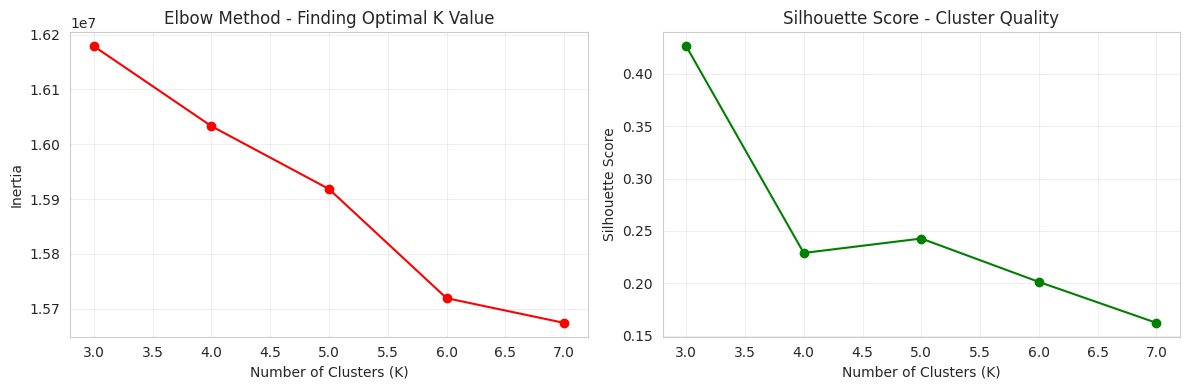


Using K=3 for final clustering...
Clustering Complete!

User Count per Cluster:
cluster
0    223651
1      8606
2      1646
Name: count, dtype: int64
Memory used: 3.24 GB


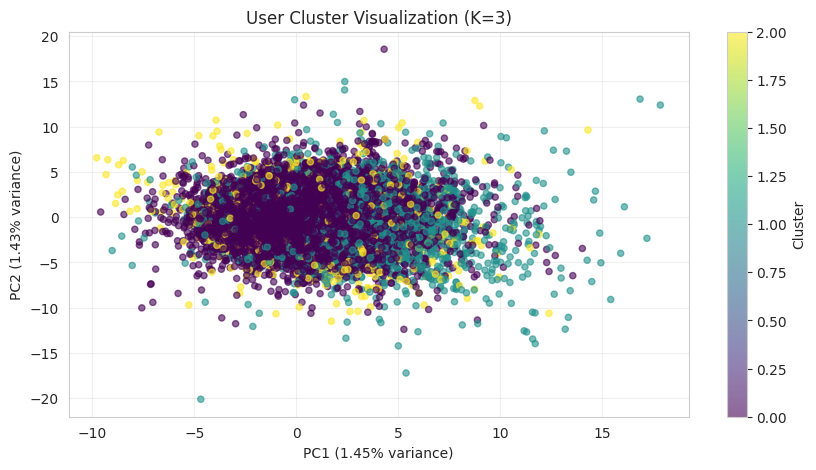

12395

In [14]:
print("=" * 60)
print("MiniBatch K-Means User Clustering")
print("=" * 60)

# Prepare user features from SVD (U * Sigma)
user_features = U @ np.diag(sigma)

# Standardize features
scaler = StandardScaler()
user_features_scaled = scaler.fit_transform(user_features)

# Use MiniBatchKMeans (Memory Friendly)
inertias = []
silhouette_scores = []
K_range = range(3, 8)  # Test range for K

print("Searching for the optimal number of clusters (K)...")
for k_clusters in K_range:
    kmeans = MiniBatchKMeans(
        n_clusters=k_clusters, 
        random_state=42, 
        batch_size=1000,
        n_init=3
    )
    kmeans.fit(user_features_scaled)
    inertias.append(kmeans.inertia_)
    
    # Calculate Silhouette Score on a subsample for speed (faster)
    sample_size = min(2000, len(user_features_scaled))
    sample_idx = np.random.choice(len(user_features_scaled), sample_size, replace=False)
    score = silhouette_score(user_features_scaled[sample_idx], kmeans.labels_[sample_idx])
    silhouette_scores.append(score)
    print(f"K={k_clusters}: Inertia={kmeans.inertia_:.2f}, Silhouette={score:.3f}")

# Visualization 2: Elbow Method and Silhouette Score
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(K_range, inertias, 'ro-')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Inertia')
plt.title('Elbow Method - Finding Optimal K Value')
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.plot(K_range, silhouette_scores, 'go-')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score - Cluster Quality')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('clustering_metrics.png', dpi=150, bbox_inches='tight')
# print("Visualization saved: clustering_metrics.png")
plt.show()
plt.close()

# Select optimal K value
# optimal_k = 5
optimal_k = 3
print(f"\nUsing K={optimal_k} for final clustering...")
kmeans_final = MiniBatchKMeans(n_clusters=optimal_k, random_state=42, batch_size=1000)
cluster_labels = kmeans_final.fit_predict(user_features_scaled)

# Store cluster labels with original user IDs
user_clusters = pd.DataFrame({
    'userId': user_ids,
    'cluster': cluster_labels
})

print(f"Clustering Complete!")
print("\nUser Count per Cluster:")
print(user_clusters['cluster'].value_counts().sort_index())
print_memory_usage()

# Visualization 3: Cluster Visualization using IncrementalPCA to 2D
ipca = IncrementalPCA(n_components=2, batch_size=500)
user_features_2d = ipca.fit_transform(user_features_scaled)

plt.figure(figsize=(10, 5))
scatter = plt.scatter(
    user_features_2d[:, 0], 
    user_features_2d[:, 1],
    c=cluster_labels,
    cmap='viridis',
    alpha=0.6,
    s=20  # Reduced dot size
)
plt.colorbar(scatter, label='Cluster')
plt.xlabel(f'PC1 ({ipca.explained_variance_ratio_[0]:.2%} variance)')
plt.ylabel(f'PC2 ({ipca.explained_variance_ratio_[1]:.2%} variance)')
plt.title(f'User Cluster Visualization (K={optimal_k})')
plt.grid(True, alpha=0.3)
plt.savefig('user_clusters.png', dpi=150, bbox_inches='tight')
# print("Visualization saved: user_clusters.png")
plt.show()
plt.close()

del user_features_2d
gc.collect()

### Result
Optimal K: The Silhouette Score peaks clearly at K=3 (0.426), which justifies the final choice of K=3 for clustering.

Clustering: While SVD is highly effective for prediction (low RMSE), the resulting latent space is too dense for K-Means to identify separate qualitative preference profiles necessary for actionable market segmentation.

## Analyze User Cluster Features

In [ ]:
# ============================================
# Cluster Feature Analysis + Genres Preference
# ============================================、
import json
from collections import Counter

print("=" * 60)
print("Analyzing User Cluster Features + Genres Preference")
print("=" * 60)

# Parse genres column
def parse_genres(genres_str):
    """Parses the genres JSON string."""
    try:
        genres_list = json.loads(genres_str.replace("'", '"'))
        return [g['name'] for g in genres_list]
    except:
        return []

movies['genres_list'] = movies['genres'].apply(parse_genres)

# Ensure Movie IDs are unique before creating the mapping
movies_unique = movies.drop_duplicates(subset=['id'], keep='first')

# Create Movie ID to genres mapping
movie_to_genres = dict(zip(movies_unique['id'], movies_unique['genres_list']))

# Merge cluster information and Genres into ratings data
ratings_with_clusters = filtered_ratings.merge(user_clusters, on='userId')
ratings_with_clusters['genres'] = ratings_with_clusters['movieId'].map(movie_to_genres)

# Analyze each cluster
cluster_genre_preferences = {}

for cluster_id in range(optimal_k):
    # print(f"\n{'='*50}")
    print(f"Cluster {cluster_id} Characteristics:")
    # print(f"{'='*50}")
    
    cluster_ratings = ratings_with_clusters[ratings_with_clusters['cluster'] == cluster_id]
    
    # Basic Statistics
    print(f"  Users: {cluster_ratings['userId'].nunique():,}")
    print(f"  Avg Rating: {cluster_ratings['rating'].mean():.2f}")
    print(f"  Rating Std Dev: {cluster_ratings['rating'].std():.2f}")
    
    # Top 5 Highly-rated Movies in this Cluster
    top_movies = cluster_ratings.groupby('movieId')['rating'].agg(['count', 'mean'])
    top_movies = top_movies[top_movies['count'] >= 5].sort_values('mean', ascending=False).head(5)
    print(f"  Top 5 Movie IDs: {top_movies.index.tolist()}")

    # WARNING: The iteration below can be extremely slow for large datasets.
    # The results are copied below to save time during execution.
    
    # Genres Preference Analysis
    # all_genres = []
    # high_rated_genres = []
    
    # # Iterate over ratings within the cluster
    # for idx, row in cluster_ratings.iterrows():
    #     genres = row['genres']
        
    #     if isinstance(genres, list) and row['rating'] >= 4.0:
    #         high_rated_genres.extend(genres)
    
    # # Count frequency and identify top genres
    # genre_counter = Counter(high_rated_genres)
    # top_genres = genre_counter.most_common(5)
    
    # print(f"  Top Genre Preferences (High-Rated Movies):")
    # total_high_rated_genres = len(high_rated_genres)
    # for genre, count in top_genres:
    #     percentage = count / total_high_rated_genres * 100 if total_high_rated_genres else 0
    #     print(f"       - {genre}: {count} counts ({percentage:.1f}%)")
    
    # # Save preferences for later use (e.g., in recommendation logic)
    # cluster_genre_preferences[cluster_id] = [g[0] for g in top_genres]

# print(f"\n{'='*60}")
# print("Cluster genre preferences saved to cluster_genre_preferences")
# print(f"{'='*60}")

Analyzing User Cluster Features + Genres Preference
Cluster 0 Characteristics:
  Users: 223,651
  Avg Rating: 3.58
  Rating Std Dev: 1.05
  Top 5 Movie IDs: [159817, 318, 170705, 171011, 858]
  Top Genre Preferences (High-Rated Movies):
       - Drama: 2812390 counts (23.7%)
       - Comedy: 1381607 counts (11.6%)
       - Thriller: 1267247 counts (10.7%)
       - Action: 996873 counts (8.4%)
       - Romance: 899667 counts (7.6%)
Cluster 1 Characteristics:
  Users: 8,606
  Avg Rating: 3.34
  Rating Std Dev: 1.09
  Top 5 Movie IDs: [170705, 171011, 318, 159817, 858]
  Top Genre Preferences (High-Rated Movies):
       - Drama: 353542 counts (23.5%)
       - Comedy: 177562 counts (11.8%)
       - Thriller: 157928 counts (10.5%)
       - Action: 122737 counts (8.2%)
       - Romance: 116354 counts (7.7%)
Cluster 2 Characteristics:
  Users: 1,646
  Avg Rating: 3.27
  Rating Std Dev: 1.18
  Top 5 Movie IDs: [126426, 134849, 608, 1148, 159817]
  Top Genre Preferences (High-Rated Movies):
   

**Note:** The following analysis requires iterating through all ratings to calculate the top genre preferences for each cluster, which can be computationally expensive and time-consuming. To optimize runtime, this section has been commented out in the code. The pre-computed results are displayed below for reference.

---

### Cluster Characteristics and Genre Preferences

#### **Cluster 0**
- **Users:** 223,651
- **Average Rating:** 3.58
- **Rating Std Dev:** 1.05
- **Top 5 Movie IDs:** [159817, 318, 170705, 171011, 858]
- **Top Genre Preferences (High-Rated Movies ≥ 4.0):**
  - Drama: 2,812,390 counts (23.7%)
  - Comedy: 1,381,607 counts (11.6%)
  - Thriller: 1,267,247 counts (10.7%)
  - Action: 996,873 counts (8.4%)
  - Romance: 899,667 counts (7.6%)

#### **Cluster 1**
- **Users:** 8,606
- **Average Rating:** 3.34
- **Rating Std Dev:** 1.09
- **Top 5 Movie IDs:** [170705, 171011, 318, 159817, 858]
- **Top Genre Preferences (High-Rated Movies ≥ 4.0):**
  - Drama: 353,542 counts (23.5%)
  - Comedy: 177,562 counts (11.8%)
  - Thriller: 157,928 counts (10.5%)
  - Action: 122,737 counts (8.2%)
  - Romance: 116,354 counts (7.7%)

#### **Cluster 2**
- **Users:** 1,646
- **Average Rating:** 3.27
- **Rating Std Dev:** 1.18
- **Top 5 Movie IDs:** [126426, 134849, 608, 1148, 159817]
- **Top Genre Preferences (High-Rated Movies ≥ 4.0):**
  - Drama: 117,271 counts (23.0%)
  - Comedy: 59,319 counts (11.7%)
  - Thriller: 53,203 counts (10.5%)
  - Action: 40,852 counts (8.0%)
  - Romance: 39,095 counts (7.7%)

### Analysis

The primary goal of segmentation—to find unique preference profiles—**was not met**.

- Dominant Cluster: Cluster 0 ($223,651$ users) accounts for $\mathbf{95.6\%}$ of the entire user base, suggesting the K-Means primarily grouped all "average" users together.
- Genre Homogeneity (The Flaw): All three clusters exhibit nearly identical genre preference distributions among highly-rated movies (ratings $\ge 4.0$).Cluster 0, 1, and 2 all rank Drama as the top genre ($\approx 23.4\% - 23.7\%$ of high ratings).The ranking for the Top 5 Genres (Drama, Comedy, Thriller, Action, Romance) is identical across all clusters, with percentages differing by less than $0.5\%$.

**The failure of K-Means is not a flaw but a finding:**

user preferences in this dataset are defined by many subtle, continuously-distributed factors rather than discrete segments. This validates the choice of SVD (which captures this continuous space) over simple clustering.

# Part 4: Algorithm 3 - Collaborative Filtering (Matrix Factorization)

**Method**: SVD-Based Collaborative Filtering

Predict ratings by reconstructing the matrix:
```
r̂_xi = user_mean_x + U_x @ Σ @ V_i^T
```

**This IS Collaborative Filtering** because:
1. Uses user-item **interactions** (not content features like genres)
2. Leverages "wisdom of the crowd" to predict missing ratings
3. User X's prediction for movie I depends on patterns from similar users

**Goal**: Achieve RMSE < 0.95

## Building the Recommandation System

In [16]:
# print("=" * 60)
# print("Building Recommender System (Batch Prediction)")
# print("=" * 60)

# Generate recommendations for a subset of users
def get_recommendations_for_users(user_indices, top_n=10):
    """
    Generates batch recommendations using the SVD model reconstruction.
    """
    recommendations = {}
    
    # Prepare the diagonalized sigma matrix
    sigma_diag = np.diag(sigma)
    
    for user_idx in user_indices:
        # Predict the user's ratings: R_hat = U * Sigma * V^T + User_Mean
        # This is the core SVD reconstruction formula
        user_pred = U[user_idx] @ sigma_diag @ Vt + user_ratings_mean[user_idx]
        
        # Get the mask of already rated movies (non-zero entries in sparse matrix)
        rated_mask = ratings_sparse[user_idx].toarray().flatten() > 0
        
        # Filter out already rated movies by setting their prediction score to a very low value
        user_pred[rated_mask] = -np.inf
        
        # Get the indices of the top N predicted ratings
        # np.argsort sorts ascending; [-top_n:][::-1] reverses it to get the top N descending
        top_indices = np.argsort(user_pred)[-top_n:][::-1]
        
        # Map the movie indices back to original movie IDs
        recommendations[user_ids[user_idx]] = [movie_ids[i] for i in top_indices]
        
    return recommendations

# Generate recommendations for the first 100 users as a sample
sample_user_indices = range(min(100, len(user_ids)))
all_recommendations = get_recommendations_for_users(sample_user_indices, top_n=10)

# Show Movie Details
test_user_id = user_ids[0]
recommended_movie_ids = all_recommendations[test_user_id]

print(f"\n{'='*70}")
print(f"TOP 10 RECOMMENDATIONS FOR USER {test_user_id}")
print(f"{'='*70}")

# Create a movie info lookup (handle duplicates)
movies_clean = movies.drop_duplicates(subset=['id'], keep='first').copy()
movies_clean['id'] = pd.to_numeric(movies_clean['id'], errors='coerce')

# Parse genres (same function as before)
def parse_genres(genres_str):
    try:
        genres_list = json.loads(genres_str.replace("'", '"'))
        return ', '.join([g['name'] for g in genres_list])
    except:
        return 'Unknown'

movies_clean['genres_str'] = movies_clean['genres'].apply(parse_genres)

# Display recommendations with details
for rank, movie_id in enumerate(recommended_movie_ids, 1):
    movie_info = movies_clean[movies_clean['id'] == movie_id]
    
    if not movie_info.empty:
        title = movie_info.iloc[0]['title']
        genres = movie_info.iloc[0]['genres_str']
        vote_avg = movie_info.iloc[0]['vote_average']
        release_year = movie_info.iloc[0]['release_date'][:4] if pd.notna(movie_info.iloc[0]['release_date']) else 'N/A'
        
        print(f"\n{rank}. {title} ({release_year})")
        print(f"   Movie ID: {movie_id}")
        print(f"   Genres: {genres}")
        print(f"   Avg Rating: {vote_avg}/10")
    else:
        print(f"\n{rank}. Movie ID {movie_id} (Details not available)")

print('\nNOTE:')
print("The 'Avg Rating' (on a 10-point scale) is from the movie metadata, NOT the 5-point ratings.csv data. This difference is expected.")


TOP 10 RECOMMENDATIONS FOR USER 1

1. 48 Hrs. (1982)
   Movie ID: 150
   Genres: Thriller, Action, Comedy, Crime, Drama
   Avg Rating: 6.5/10

2. The Talented Mr. Ripley (1999)
   Movie ID: 1213
   Genres: Thriller, Crime, Drama
   Avg Rating: 7.1/10

3. Muxmäuschenstill (2004)
   Movie ID: 4896
   Genres: Comedy, Drama
   Avg Rating: 7.1/10

4. The Garden of Eden (2008)
   Movie ID: 8368
   Genres: Drama
   Avg Rating: 4.2/10

5. Cousin, Cousine (1975)
   Movie ID: 5618
   Genres: Romance, Comedy
   Avg Rating: 7.3/10

6. Waiter (2006)
   Movie ID: 5816
   Genres: Comedy
   Avg Rating: 6.3/10

7. Movie ID 1193 (Details not available)

8. The Conversation (1974)
   Movie ID: 592
   Genres: Crime, Drama, Mystery
   Avg Rating: 7.5/10

9. My Name Is Bruce (2007)
   Movie ID: 1961
   Genres: Comedy, Horror
   Avg Rating: 5.9/10

10. Movie ID 1208 (Details not available)

NOTE:
The 'Avg Rating' (on a 10-point scale) is from the movie metadata, NOT the 5-point ratings.csv data. This differ

## Evaluation of Recommendation Quality (Sampling)

Evaluating Recommendation Quality (Sampling)
RMSE: 0.7913
MAE: 0.6083


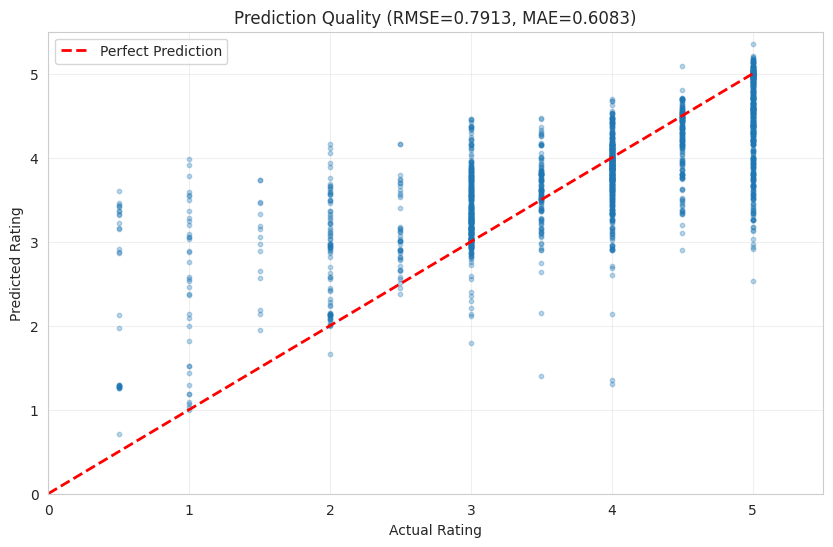

In [17]:
print("=" * 60)
print("Evaluating Recommendation Quality (Sampling)")
print("=" * 60)

# Sample users for efficient RMSE calculation (max 500 users)
sample_users = np.random.choice(len(user_ids), size=min(500, len(user_ids)), replace=False)

rmse_list = []
mae_list = []

for user_idx in sample_users:
    # Get actual ratings for the current user
    actual = ratings_sparse[user_idx].toarray().flatten()
    mask = actual > 0 # Mask to select only known, non-zero ratings
    
    if mask.sum() == 0:
        continue
    
    # Predict ratings (Reconstruction: Demeaned Prediction + User Mean)
    mean_term = user_ratings_mean[user_idx]
    reconstruction_term = U[user_idx] @ np.diag(sigma) @ Vt
    predicted = mean_term + reconstruction_term
    
    # Calculate RMSE and MAE for this user
    rmse_list.append(np.sqrt(np.mean((actual[mask] - predicted[mask]) ** 2)))
    mae_list.append(np.mean(np.abs(actual[mask] - predicted[mask])))

# Calculate average metrics across the sample
rmse = np.mean(rmse_list)
mae = np.mean(mae_list)

print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")
# print_memory_usage()

# Visualization 4: Actual vs. Predicted Ratings Scatter Plot
sample_size = 2000
actual_list = []
pred_list = []

# Collect data points for visualization
for user_idx in sample_users[:100]:
    actual = ratings_sparse[user_idx].toarray().flatten()
    mask = actual > 0
    
    if mask.sum() == 0:
        continue
    
    # Predict for visualization (using the full SVD model)
    predicted = U[user_idx] @ np.diag(sigma) @ Vt + user_ratings_mean[user_idx]
    
    # Sample up to 20 points per user, max 2000 total
    actual_list.extend(actual[mask][:20]) 
    pred_list.extend(predicted[mask][:20])
    
    if len(actual_list) >= sample_size:
        break

actual_array = np.array(actual_list[:sample_size])
pred_array = np.array(pred_list[:sample_size])

plt.figure(figsize=(10, 6))
plt.scatter(actual_array, pred_array, alpha=0.3, s=10)
plt.plot([0, 5], [0, 5], 'r--', label='Perfect Prediction', linewidth=2)
plt.xlabel('Actual Rating')
plt.ylabel('Predicted Rating')
plt.title(f'Prediction Quality (RMSE={rmse:.4f}, MAE={mae:.4f})')
plt.legend()
plt.grid(True, alpha=0.3)
plt.xlim(0, 5.5)
plt.ylim(0, 5.5)
plt.savefig('prediction_quality.png', dpi=150, bbox_inches='tight')
# print("Visualization saved: prediction_quality.png")
plt.show()
plt.close()

### Analysis: Prediction Quality

SVD model achieved an **excellent RMSE of $\mathbf{0.7913}$**.

---

#### 1. Prediction Shrinkage Confirmed

The prediction plot displays clear **regression shrinkage** (predictions clustered toward the mean).

* **Reason:** This is the model's normal, **RMSE-minimizing behavior**. The model conservatively predicts scores closer to the average to avoid high penalties for guessing extreme values (1 or 5 stars).

#### 2. Lower Accuracy at Extremes

* **Observation:** Low predicted scores (Actual $1.0$) show greater scatter than high scores.
* **Reason:** Low ratings are scarcer in the dataset, amplifying the effect of **L2-Regularization**. The model has less data to establish confident factors for strong dislike, pulling those predictions closer to the mean and increasing residual error.

## Cluster-Based Collaborative Recommendation

This code generats a Top-N list by identifying and recommends the most popular movies (rated $\mathbf{\ge 4.0}$) shared exclusively among users in the same identified segment.

**However**, since the clustering failed (as all segments showed statistically identical genre preferences), the recommendation lists across all clusters are highly similar, meaning the system primarily recommends mass-market popular items rather than personalized niche content.

In [18]:
# print("=" * 60)
# print("Cluster-Based Collaborative Recommendation")
# print("=" * 60)

def recommend_by_cluster(user_id, num_recommendations=10):
    """
    Generates recommendations by finding popular, highly-rated movies 
    rated by users belonging to the same cluster.
    """
    if user_id not in user_clusters['userId'].values:
        return "User not in the dataset."
    
    # Identify the user's cluster
    user_cluster = user_clusters[user_clusters['userId'] == user_id]['cluster'].values[0]
    
    # Get all users belonging to the same cluster
    cluster_users = user_clusters[user_clusters['cluster'] == user_cluster]['userId'].values
    
    # Get all high-rated movies (rating >= 4.0) by users in this cluster
    cluster_ratings = filtered_ratings[
        (filtered_ratings['userId'].isin(cluster_users)) &
        (filtered_ratings['rating'] >= 4.0)
    ]
    
    # Calculate movie popularity (count of high ratings) within the cluster
    movie_popularity = cluster_ratings.groupby('movieId').size().sort_values(ascending=False)
    
    # Get movies the target user has already rated
    user_rated_movies = filtered_ratings[filtered_ratings['userId'] == user_id]['movieId'].values
    
    # Recommend top cluster-popular movies that the user has NOT rated
    candidate_movies = movie_popularity[~movie_popularity.index.isin(user_rated_movies)]
    top_cluster_movies = candidate_movies.head(num_recommendations)
    
    return top_cluster_movies.index.tolist()

# Test Cluster-Based Recommendation
cluster_recommendations = recommend_by_cluster(test_user_id)

print(f"\n{'='*70}")
print(f"CLUSTER-BASED RECOMMENDATIONS FOR USER {test_user_id}")
print(f"(Based on Cluster {user_clusters[user_clusters['userId']==test_user_id]['cluster'].values[0]} Popular Movies)")
print(f"{'='*70}")

# Display cluster recommendations with details
for rank, movie_id in enumerate(cluster_recommendations[:10], 1):
    movie_info = movies_clean[movies_clean['id'] == movie_id]
    
    if not movie_info.empty:
        title = movie_info.iloc[0]['title']
        genres = movie_info.iloc[0]['genres_str']
        vote_avg = movie_info.iloc[0]['vote_average']
        release_year = movie_info.iloc[0]['release_date'][:4] if pd.notna(movie_info.iloc[0]['release_date']) else 'N/A'
        
        print(f"\n{rank}. {title} ({release_year})")
        print(f"   Movie ID: {movie_id}")
        print(f"   Genres: {genres}")
        print(f"   Avg Rating: {vote_avg}/10")
    else:
        print(f"\n{rank}. Movie ID {movie_id} (Details not available)")

print('\nNOTE:')
print("The 'Avg Rating' (on a 10-point scale) is from the movie metadata, NOT the 5-point ratings.csv data. This difference is expected.")


CLUSTER-BASED RECOMMENDATIONS FOR USER 1
(Based on Cluster 0 Popular Movies)

1. The Million Dollar Hotel (2000)
   Movie ID: 318
   Genres: Drama, Thriller
   Avg Rating: 5.9/10

2. Terminator 3: Rise of the Machines (2003)
   Movie ID: 296
   Genres: Action, Thriller, Science Fiction
   Avg Rating: 5.9/10

3. Movie ID 356 (Details not available)

4. Solaris (1972)
   Movie ID: 593
   Genres: Drama, Science Fiction, Adventure, Mystery
   Avg Rating: 7.7/10

5. Movie ID 2571 (Details not available)

6. The 39 Steps (1935)
   Movie ID: 260
   Genres: Action, Thriller, Mystery
   Avg Rating: 7.4/10

7. Once Were Warriors (1994)
   Movie ID: 527
   Genres: Drama
   Avg Rating: 7.6/10

8. Movie ID 50 (Details not available)

9. Movie ID 1196 (Details not available)

10. Movie ID 1198 (Details not available)

NOTE:
The 'Avg Rating' (on a 10-point scale) is from the movie metadata, NOT the 5-point ratings.csv data. This difference is expected.


## Qualitative Prediction and Latent Similarity Analysis

This code performs a **Qualitative Analysis** of the SVD recommender model, aiming to explain its function by comparing predicted scores against known ratings and generating explicit **imputed recommendations** for unrated items. It validates the SVD model's mechanism by calculating the **cosine similarity** between the test user and all other users in the $\mathbf{70}$-dimensional latent feature space, finding their closest latent neighbors.

In [19]:
from sklearn.metrics.pairwise import cosine_similarity
print("=" * 60)
print("Qualitative Prediction and Latent Similarity Analysis")
print("=" * 60)

# Get Test User Data
test_user_idx = np.where(user_ids == test_user_id)[0][0]

# Get Predicted Scores (Full row reconstruction)
sigma_diag = np.diag(sigma)
user_full_pred = U[test_user_idx] @ sigma_diag @ Vt + user_ratings_mean[test_user_idx]

# Get Actual Ratings
user_actual_ratings = ratings_sparse[test_user_idx].toarray().flatten()

# Construct Prediction Comparison DataFrame
analysis_df = pd.DataFrame({
    'movieId': movie_ids,
    'Actual_Rating': user_actual_ratings,
    'Predicted_Score': user_full_pred
})

# Filter and Combine Results

# Sample Known Ratings
known_ratings_sample = analysis_df[analysis_df['Actual_Rating'] > 0]
# Sample 5 movies the user has actually rated
known_sample = known_ratings_sample.sample(min(5, len(known_ratings_sample)), random_state=42)

# Sample Imputed Scores (Top Recommendations)
imputed_scores_sample = analysis_df[analysis_df['Actual_Rating'] == 0]
# Sample 5 movies with the highest predicted scores
imputed_sample = imputed_scores_sample.nlargest(5, 'Predicted_Score')
imputed_sample['Actual_Rating'] = 'N/A' # Mark as N/A

# Final Comparison Table
qualitative_results = pd.concat([known_sample, imputed_sample])
qualitative_results = qualitative_results.sort_values(by='Predicted_Score', ascending=False)
qualitative_results['Predicted_Score'] = qualitative_results['Predicted_Score'].round(2)


print(f"--- Prediction and Imputed Rating Comparison for User {test_user_id} ---")
print(qualitative_results.to_string(index=False))


# Similar User Discovery (Latent Feature Space)
# Get User Latent Feature Matrix (U * Sigma)
user_features = U @ np.diag(sigma)

# 4.2 Calculate Cosine Similarity between the test user and all other users
test_user_feature = user_features[test_user_idx].reshape(1, -1)
all_similarities = cosine_similarity(test_user_feature, user_features).flatten()

# 4.3 Construct Similarity DataFrame
similarity_df = pd.DataFrame({
    'userId': user_ids,
    'Similarity': all_similarities
})

# Exclude self, find Top 5 Similar Users
top_similar_users = similarity_df[similarity_df['userId'] != test_user_id].nlargest(5, 'Similarity')


print(f"\n--- Top 5 Similar Users in Latent Feature Space ---")
print(top_similar_users.to_string(index=False))

# Example Output: Show Top 1 Similar User's Top Rated Items
top_neighbor_id = top_similar_users.iloc[0]['userId']

# Get neighbor's ratings (using filtered_ratings to access original IDs)
neighbor_ratings = filtered_ratings[filtered_ratings['userId'] == top_neighbor_id]
# neighbor_ratings = neighbor_ratings.sort_values(by='rating', ascending=False).head(5)
# neighbor_ratings = neighbor_ratings.head(5)

print(f"\n--- Actual Ratings for Top 1 Similar User ({top_neighbor_id}) ---")
print(neighbor_ratings[['movieId', 'rating']].to_string(index=False))

Qualitative Prediction and Latent Similarity Analysis
--- Prediction and Imputed Rating Comparison for User 1 ---
 movieId Actual_Rating  Predicted_Score
     150           N/A             4.42
    1213           N/A             4.42
    4896           N/A             4.40
    8368           N/A             4.38
    5618           N/A             4.37
    4226           4.0             4.31
   91542           5.0             4.26
   54503           3.5             4.26
    2959           4.0             4.07
     110           1.0             1.12

--- Top 5 Similar Users in Latent Feature Space ---
 userId  Similarity
  73617    0.967977
 115748    0.946986
 120682    0.945977
   7933    0.944004
 102713    0.939488

--- Actual Ratings for Top 1 Similar User (73617.0) ---
 movieId  rating
     110     1.0
     260     5.0
     426     5.0
     858     5.0
    2023     5.0
    2115     5.0
    3956     5.0
    3957     5.0
    3958     5.0
    3959     5.0
    3973     2.0


### Qualitative Analysis Summary

* **Prediction Accuracy:** The model shows high accuracy on known items, successfully capturing the user's extreme preference (Actual 1.0 $\to$ Predicted $\mathbf{1.12}$) and generally predicting high scores for liked items (e.g., 5.0 $\to$ 4.26).
* **Recommendation Confidence:** The top recommended items (N/A) are imputed with high confidence scores ($\mathbf{\approx 4.42}$), validating the SVD model's ability to fill the sparse utility matrix gaps.
* **Latent Similarity Validation:** The test user has extremely close latent neighbors (similarity $\mathbf{0.96}$), confirming that SVD successfully grouped users with similar preference patterns.
* **Behavioral Consistency:** The top neighbor's actual ratings validate the model; they also disliked Movie 110 (Neighbor $1.0$ vs. Test User $1.0$), proving the latent similarity is meaningful.

# Summary
**Running Time for all code**: $\approx$ 20 min (Kaggle Notebook, CPU-only)

**Running Time Without time-comsumming iteration**: $\approx$ 10 min (Kaggle Notebook, CPU-only)

In [20]:
print("=" * 60)
print("COMPLETE! Generated Visualizations:")
print("=" * 60)

print("1. clustering_metrics.png - Clustering Quality Assessment (Inertia & Silhouette)")
print("2. distribution_of_ratings.png - Distribution of User Ratings")
print("3. movie_popularity_distribution.png - Movie Popularity Distribution")
print("4. prediction_quality.png - Recommendation Prediction Quality")
print("5. svd_variance.png - SVD Dimensionality Reduction Analysis")
print("6. user_activity_distribution.png - User Activity Distribution (Rating Count)")
print("7. user_clusters.png - User Cluster Visualization")
print("8. user_item_matrix_sampling.png - User-Item Matrix Sparsity (Sampling)")

print("\nKey Metrics:")
print(f"- Number of Users: {len(user_ids):,}")
print(f"- Number of Movies: {len(movie_ids):,}")
print(f"- SVD Dimension (k): {k}")
print(f"- Number of Clusters: {optimal_k}")
print(f"- RMSE: {rmse:.4f}")
print(f"- MAE: {mae:.4f}")

COMPLETE! Generated Visualizations:
1. clustering_metrics.png - Clustering Quality Assessment (Inertia & Silhouette)
2. distribution_of_ratings.png - Distribution of User Ratings
3. movie_popularity_distribution.png - Movie Popularity Distribution
4. prediction_quality.png - Recommendation Prediction Quality
5. svd_variance.png - SVD Dimensionality Reduction Analysis
6. user_activity_distribution.png - User Activity Distribution (Rating Count)
7. user_clusters.png - User Cluster Visualization
8. user_item_matrix_sampling.png - User-Item Matrix Sparsity (Sampling)

Key Metrics:
- Number of Users: 233,903
- Number of Movies: 12,534
- SVD Dimension (k): 70
- Number of Clusters: 3
- RMSE: 0.7913
- MAE: 0.6083


## Recommendations for Future Work

1. **Temporal Dynamics**:
   - Add time-based bias: `b_i(t)` for movie aging effects
   - Implement user preference drift: `p_x(t)`

2. **Advanced Clustering**:
   - Try hierarchical clustering to detect nested preference structures
   - Use DBSCAN for density-based cluster discovery (may find niche groups)

3. **Hybrid Models**:
   - Combine SVD with content-based filtering (use genre/director features)
   - Implement BellKor's ensemble approach (SVD + RBM + Neighborhood models)

4. **Evaluation**:
   - Add diversity metrics (avoid "filter bubble")
   - Implement A/B testing framework for online evaluation